### Model 2 for Leaf counting

In [1]:
# Installing necessary libraries
!pip install tensorflow_addons
!pip install tensorflow==2.8
!apt-get install libcudnn8


  Using cached tensorflow_addons-0.17.1-cp37-cp37m-win_amd64.whl (758 kB)
  Using cached typeguard-2.13.3-py3-none-any.whl (17 kB)


You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.


  Using cached tensorflow-2.8.0-cp37-cp37m-win_amd64.whl (437.9 MB)
  Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.0
    Uninstalling tensorboard-2.9.0:
      Successfully uninstalled tensorboard-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.1
    Uninstalling tensorflow-2.9.1:
      Successfully uninstalled tensorflow-2.9.1


You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python37\python.exe -m pip install --upgrade pip' command.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time 
import datetime
import os 

import sklearn
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_addons as tfa
# from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Flatten, BatchNormalization, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


### Setting the parameters

In [4]:
data_path = r"../datasets"
checkpoint_path = r"../Model_checkpoints/Model_Model_2/"

input_shape = (512, 512, 3)
image_shape = [512, 512]

BATCH_SIZE = 8
BUFFER_SIZE = 150
repeat_count = None

num_threads = 4

EPOCHS = 101
learning_rate=1e-5
patience = 21

### TensorFlow functions

In [5]:
# Load the images from paths
@tf.function
def get_images_and_counts(image_path, count):
    '''
    Reading image as a tensor, converting its value to float and reshaping.
    @param image_path: Path to the original image
    @param count: number of leaves
    @return: image that is now a tensor resized into the dimensions defined by image_shape, and count
    '''
    image = tf.io.decode_png(tf.io.read_file(image_path), channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float64)
    image = tf.image.resize(image, image_shape)
    return image, count


# Data augmentation
@tf.function
def data_augmentation(image, count):
    '''
    Function for applying different augmentation techniques to the images.
    @param image: tensor representing image
    @param count: number of leaves
    @return: image that is transformed and count
    '''
    random_number = tf.random.uniform(shape = [], maxval = 7, dtype = tf.int32)
    print(random_number)
    # apply rotation by 90 
    if tf.equal(random_number, tf.constant(1)):
        image = tfa.image.rotate(image, 90, interpolation = "NEAREST") 
    
    # apply rotation by 180 
    elif tf.equal(random_number, tf.constant(2)):
        image = tfa.image.rotate(image, 180, interpolation = "NEAREST")
        
    # apply rotation by 270 
    elif tf.equal(random_number, tf.constant(3)):
        image = tfa.image.rotate(image, 270, interpolation = "NEAREST") 
        
    # apply horizontal flip
    elif tf.equal(random_number, tf.constant(4)):
        image = tf.image.flip_left_right(image)
        
    # apply vertical flip
    elif tf.equal(random_number, tf.constant(5)):
        image = tf.image.flip_up_down(image)
            
    # apply gaussian blur
    elif tf.equal(random_number, tf.constant(6)):
        image = tfa.image.gaussian_filter2d(image, filter_shape = 3, sigma = 16.6, padding = "SYMMETRIC")
    
    return image, count


### Loading image paths and counts for datasets A1, A2, A4, and A_PSI

In [6]:
### A1
images_A1 = np.empty(shape=128, dtype=object)
counts_A1 = np.empty(shape=128, dtype=float)

index = 0

csv_path = data_path + "/A1/A1.csv"
images_and_counts_cvs = pd.read_csv(csv_path, names=['Image_name', 'Count'])
for ind, row in images_and_counts_cvs.iterrows():
    images_A1[index] = data_path + '/A1/' + row['Image_name']
    counts_A1[index] = row['Count']
    index += 1

### A2
images_A2 = np.empty(shape=31, dtype=object)
counts_A2 = np.empty(shape=31, dtype=float)

index = 0

csv_path = data_path + "/A2/A2.csv"
images_and_counts_cvs = pd.read_csv(csv_path, names=['Image_name', 'Count'])
for ind, row in images_and_counts_cvs.iterrows():
    images_A2[index] = data_path + '/A2/' + row['Image_name']
    counts_A2[index] = row['Count']
    index += 1

### A4
images_A4 = np.empty(shape=624, dtype=object)
counts_A4 = np.empty(shape=624, dtype=float)

index = 0

csv_path = data_path + "/A4/A4.csv"
images_and_counts_cvs = pd.read_csv(csv_path, names=['Image_name', 'Count'])
for ind, row in images_and_counts_cvs.iterrows():
    images_A4[index] = data_path + '/A4/' + row['Image_name']
    counts_A4[index] = row['Count']
    index += 1

### A_PSI 
images_A_PSI = np.empty(shape=480, dtype=object)
counts_A_PSI = np.empty(shape=480, dtype=float)

index = 0

csv_path = data_path + "/A_PSI/A_PSI.csv"
images_and_counts_cvs = pd.read_csv(csv_path, names=['Image_name', 'Count'])
for ind, row in images_and_counts_cvs.iterrows():
    image_path = (row['Image_name']).replace(".png", "_rgb.png")
    images_A_PSI[index] = data_path + '/A_PSI/' + image_path
    counts_A_PSI[index] = row['Count']
    index += 1

print(len(images_A_PSI))
print(len(counts_A_PSI))

480
480


### Setting up datasets for training

In [7]:
# only A1 used for training
images = images_A1
counts = counts_A1

# only A4 used for training
images = images_A4
counts = counts_A4

# only A_PSI used for training
images = images_A_PSI
counts = counts_A_PSI

# combination of A1 A2, and A4 used for training
images = np.concatenate([images_A1, images_A2, images_A4])
counts = np.concatenate([counts_A1, counts_A2, counts_A4])


# combination of A1 A2, A4, and A_PSI used for training
images = np.concatenate([images_A1, images_A2, images_A4, images_A_PSI])
counts = np.concatenate([counts_A1, counts_A2, counts_A4, counts_A_PSI])

128
128
[15. 11. 15. 15. 12. 14. 15. 16. 11. 13. 16. 16. 13. 14. 16. 14. 15. 18.
 14. 14. 20. 19. 16. 15. 17. 15. 14. 18. 18. 16. 15. 20. 19. 18. 17. 18.
 19. 15. 15. 18. 17. 17. 14. 18. 18. 15. 17. 16. 20. 17. 18. 16. 16. 17.
 15. 14. 18. 18. 16. 15. 18. 15. 15. 16. 19. 19. 15. 17. 19. 15. 14. 18.
 17. 15. 18. 16. 15. 16. 17. 19. 17. 16. 17. 15. 15. 17. 17. 16. 15. 18.
 15. 18. 16. 19. 19. 16. 16. 17. 15. 15. 18. 16. 15. 19. 18. 15. 17. 16.
 18. 20. 16. 15. 17. 15. 15. 16. 17. 16. 14. 19. 18. 14. 16. 16. 18. 17.
 18. 16.]
['../datasets/A1/plant001_rgb.png' '../datasets/A1/plant002_rgb.png'
 '../datasets/A1/plant005_rgb.png' '../datasets/A1/plant006_rgb.png'
 '../datasets/A1/plant007_rgb.png' '../datasets/A1/plant008_rgb.png'
 '../datasets/A1/plant010_rgb.png' '../datasets/A1/plant011_rgb.png'
 '../datasets/A1/plant012_rgb.png' '../datasets/A1/plant013_rgb.png'
 '../datasets/A1/plant015_rgb.png' '../datasets/A1/plant016_rgb.png'
 '../datasets/A1/plant017_rgb.png' '../datasets/A1/plant0

In [8]:
X_train, X_rem, y_train, y_rem = train_test_split(images, counts, random_state = 219, shuffle=True, test_size= 0.20)
X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, random_state = 271, shuffle = True, test_size = 0.50)


In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(len(X_train), reshuffle_each_iteration=True)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = train_dataset.shuffle(len(X_val))

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2022-08-22 19:10:46.445176: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-22 19:10:47.127391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10794 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7


In [10]:
train_dataset = train_dataset.map(get_images_and_counts, num_parallel_calls=num_threads).map(data_augmentation, num_parallel_calls=num_threads)
val_dataset = val_dataset.map(get_images_and_counts, num_parallel_calls=num_threads)
test_dataset = test_dataset.map(get_images_and_counts, num_parallel_calls=num_threads)

Tensor("random_uniform:0", shape=(), dtype=int32)
<ParallelMapDataset element_spec=(TensorSpec(shape=(448, 448, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float64, name=None))>


In [11]:
train_dataset = train_dataset.repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
val_dataset = val_dataset.repeat(repeat_count).batch(BATCH_SIZE).prefetch(5)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(5)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


## Model 1

In [12]:
def Conv_batch_norm_relu(input_tensor, filters, kernel):
    '''
    :param input_tensor: tensor that will be used as a parameter for a convolution
    :param filters: number of filters in convolutional layer
    :param kernel: kernel size in convolutional layer
    :return: conv consisting of convolution, batch normalization and activation using ReLU function
    '''
    conv = Conv2D(filters, kernel, padding = "same")(input_tensor)
    conv = BatchNormalization()(conv)
    conv = Activation("relu")(conv)
    return conv

In [13]:
# adding layer to the model
input = Input(shape=input_shape)

conv1 = Conv_batch_norm_relu(input, 16, (3, 3))
conv2 = Conv_batch_norm_relu(conv1, 16, (3, 3))
max_pool_1 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv2)

conv3 = Conv_batch_norm_relu(max_pool_1, 32, (3, 3))
conv4 = Conv_batch_norm_relu(conv3, 32, (3, 3))
max_pool_2 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv4)

conv5 = Conv_batch_norm_relu(max_pool_2, 64, (5,5))
conv6 = Conv_batch_norm_relu(conv5, 64, (5,5))
max_pool_3 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv6)

conv7 = Conv_batch_norm_relu(max_pool_3, 128, (5,5))
conv8 = Conv_batch_norm_relu(conv7, 128, (5,5))
max_pool_4 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv8)

conv9 = Conv_batch_norm_relu(max_pool_4, 256, (5,5))
conv10 = Conv_batch_norm_relu(conv9, 256, (5,5))
max_pool_5 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv10)

conv10 = Conv_batch_norm_relu(max_pool_5, 512, (5,5))
conv11 = Conv_batch_norm_relu(conv10, 512, (5,5))
conv12 = Conv_batch_norm_relu(conv11, 512, (5,5))
conv13 = Conv_batch_norm_relu(conv12, 512, (5,5))

max_pool_6 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(conv13)
max_pool_7 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(max_pool_6)
max_pool_8 = MaxPooling2D(pool_size = (2,2), strides=(2,2))(max_pool_7)

flat = Flatten()(max_pool_8)

fc1 = Dense(512)(flat)
fc2 = Dense(256)(fc1)

output = Dense(1)(fc2)

model = Model(inputs=[input], outputs=[output])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 448, 448, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 448, 448, 16)      3904      
                                                                 
 batch_normalization (BatchN  (None, 448, 448, 16)     64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 448, 448, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 448, 448, 16)      20752     
                                                                 
 batch_normalization_1 (Batc  (None, 448, 448, 16)     64        
 hNormalization)                                             

### Model checkpoint and early stopping

In [14]:
# defining model checkpoint with monitoring val_loss
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_loss',
    save_best_only = True,
)

# defining early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=patience)

## Training the model

In [15]:
# adding start time and printing moment of starting training
start_time = time.time()
print("Start: " + str(datetime.datetime.now()))

tf.keras.backend.clear_session()

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
    metrics= ['mse', 'accuracy']
)

fit_history = model.fit(
    train_dataset,
    epochs = EPOCHS,
    verbose = 1,
    callbacks = [model_checkpoint, early_stopping],
    steps_per_epoch = len(X_train) // BATCH_SIZE,
    validation_data = val_dataset,
    validation_steps = len(X_val) // BATCH_SIZE,
    use_multiprocessing = True
)


print("--- %s seconds ---" % (time.time() - start_time))
print("End: " + str(datetime.datetime.now()))

Start: 2022-08-22 19:10:50.134681
Epoch 1/101
12/12 [==============================] - 31s 2s/step - loss: 65.0687 - mse: 65.0687 - accuracy: 0.0000e+00 - val_loss: 212.2087 - val_mse: 212.2087 - val_accuracy: 0.0000e+00
Epoch 2/101
12/12 [==============================] - 23s 2s/step - loss: 16.9709 - mse: 16.9709 - accuracy: 0.0000e+00 - val_loss: 210.4068 - val_mse: 210.4068 - val_accuracy: 0.0000e+00
Epoch 3/101
12/12 [==============================] - 9s 731ms/step - loss: 8.7687 - mse: 8.7687 - accuracy: 0.0000e+00 - val_loss: 211.4781 - val_mse: 211.4781 - val_accuracy: 0.0000e+00
Epoch 4/101
12/12 [==============================] - 24s 2s/step - loss: 4.4224 - mse: 4.4224 - accuracy: 0.0000e+00 - val_loss: 199.8139 - val_mse: 199.8139 - val_accuracy: 0.0000e+00
Epoch 5/101
12/12 [==============================] - 24s 2s/step - loss: 7.5919 - mse: 7.5919 - accuracy: 0.0000e+00 - val_loss: 173.0706 - val_mse: 173.0706 - val_accuracy: 0.0000e+00
Epoch

2022-08-22 19:10:53.009761: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8201
2022-08-22 19:10:53.345520: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-08-22 19:11:08.933386: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


## Evaluation on test dataset

In [16]:
model.evaluate(test_dataset)

2/2 [==============================] - 2s 1s/step - loss: 0.7622 - mse: 0.7622 - accuracy: 0.0000e+00


[0.7621720433235168, 0.7621720433235168, 0.0]

#### Load the best model and evaluate on test dataset

In [17]:
best_model = tf.keras.models.load_model(checkpoint_path)
best_model.evaluate(test_dataset)

2/2 [==============================] - 1s 253ms/step - loss: 1.2962 - mse: 1.2962 - accuracy: 0.0000e+00


[1.2961769104003906, 1.2961769104003906, 0.0]

### Evaluation function calculating four metrics DiC, |DiC|, MSE and Accuracy

In [18]:
def calculate_evaluation_metrics(test_set_count, predictions, set_name):
    '''
    Calucalting metrics for leaf counting. Metrics that are calculated include: DiC, |DIC|, MSE adnd Accuracy.
    :param test_set_count: counts for test set as provided by the annotation data
    :param predictions: counts for test set as predict by the model
    :param set_name: name of the testing set
    '''
    set_len = len(test_set_count)

    print(set_name + " - DiC")
    count_diff = (test_set_count - predictions).sum() / set_len
    print(round(count_diff, 2))

    print(set_name + " - |DiC|")
    abs_count_diff = (abs(test_set_count - predictions)).sum() / set_len
    print(round(abs_count_diff, 2))

    print(set_name + " - MSE")
    mse = (pow(test_set_count - predictions, 2)).sum() / set_len
    print(round(mse, 2))

    print(set_name + " - Accuracy %")
    difference = test_set_count - predictions
    correct = sum([1 for x in difference if x == 0])
    accuracy = (correct * 100) / set_len 
    print(round(accuracy, 2))

def get_image_and_counts_arrays(images, counts):
    '''
    Getting arrays of images as a tensors and its appropriate leaf count
    :param images: list of image paths
    :param counts: list of counts
    :return: arrays of images and counts
    '''
    test_set_images = []
    test_set_count = []

    for image, count in zip(images, counts):
        image, count = get_images_and_counts(image, count)
        test_set_images.append(image)
        test_set_count.append(count)

    test_set_images = np.array(test_set_images)
    test_set_count = np.array(test_set_count)

    return test_set_images, test_set_count

### Examples of good and bad predictions on test dataset

In [19]:
best_model = tf.keras.models.load_model(checkpoint_path)

test_set_images, test_set_count = get_image_and_counts_arrays(X_test, y_test)

predictions = best_model.predict(test_set_images)
predictions = [round(x[0], 0) for x in predictions]
print("Ground truth: " + str(test_set_count))
print("Predictions: " + str(predictions))

calculate_evaluation_metrics(test_set_count, predictions, "Test set")


CHEEECK
[[17.140388]
 [13.749946]
 [15.732797]
 [16.08966 ]
 [17.853909]
 [14.222665]
 [14.123765]
 [16.694086]
 [16.318336]
 [13.10682 ]
 [16.341192]
 [16.008804]
 [15.061615]]
Ground truth: [17. 15. 17. 18. 19. 14. 15. 16. 16. 15. 18. 17. 15.]
Predictions: [17.0, 14.0, 16.0, 16.0, 18.0, 14.0, 14.0, 17.0, 16.0, 13.0, 16.0, 16.0, 15.0]
Test set - DiC
0.7692307692307693
Test set - |DiC|
0.9230769230769231
Test set - MSE
1.3846153846153846
Test set - Accuracy %
30.76923076923077


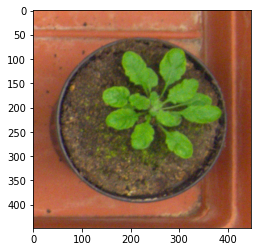

Predicted:  14.0
Ground Truth:  14.0
--------------------------------------------------


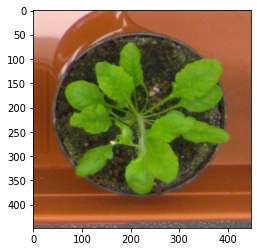

Predicted:  16.0
Ground Truth:  16.0
--------------------------------------------------


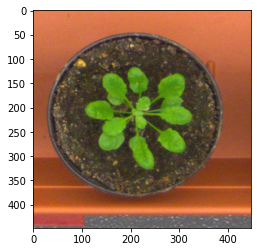

Predicted:  15.0
Ground Truth:  15.0
--------------------------------------------------


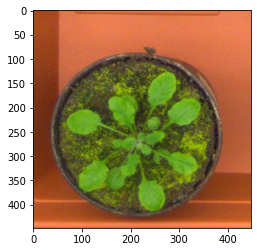

Predicted:  16.0
Ground Truth:  18.0
--------------------------------------------------


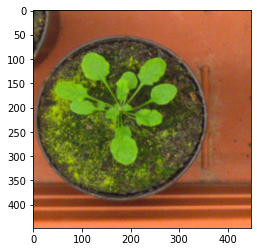

Predicted:  13.0
Ground Truth:  15.0
--------------------------------------------------


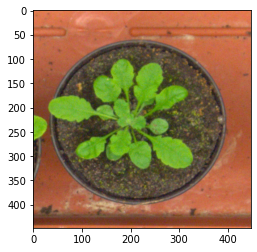

Predicted:  16.0
Ground Truth:  18.0
--------------------------------------------------


In [20]:
for i in range(len(X_test)):
    X_test[i],_ = get_images_and_counts(X_test[i], 1)

indexes = np.argsort(np.abs(test_set_count - predictions))

# Best results
plt.imshow(X_test[indexes[1]])
plt.show()
print("Predicted: ", predictions[indexes[1]])
print("Ground Truth: ", test_set_count[indexes[1]])

plt.imshow(X_test[indexes[2]])
plt.show()
print("Predicted: ", predictions[indexes[2]])
print("Ground Truth: ", test_set_count[indexes[2]])

plt.imshow(X_test[indexes[3]])
plt.show()
print("Predicted: ", predictions[indexes[3]])
print("Ground Truth: ", test_set_count[indexes[3]])

# Worst results
plt.imshow(X_test[indexes[-1]])
plt.show()
print("Predicted: ", predictions[indexes[-1]])
print("Ground Truth: ", test_set_count[indexes[-1]])

plt.imshow(X_test[indexes[-2]])
plt.show()
print("Predicted: ", predictions[indexes[-2]])
print("Ground Truth: ", test_set_count[indexes[-2]])

plt.imshow(X_test[indexes[-3]])
plt.show()
print("Predicted: ", predictions[indexes[-3]])
print("Ground Truth: ", test_set_count[indexes[-3]])

### Calculate evaluation metrics for A1 set

In [21]:
test_set_images_A1, test_set_count_A1 = get_image_and_counts_arrays(images_A1, counts_A1)

predictions = best_model.predict(test_set_images_A1)
predictions = [round(x[0], 0) for x in predictions]

calculate_evaluation_metrics(test_set_count_A1, predictions, "A1")

Ground truth: [15. 11. 15. 15. 12. 14. 15. 16. 11. 13. 16. 16. 13. 14. 16. 14. 15. 18.
 14. 14. 20. 19. 16. 15. 17. 15. 14. 18. 18. 16. 15. 20. 19. 18. 17. 18.
 19. 15. 15. 18. 17. 17. 14. 18. 18. 15. 17. 16. 20. 17. 18. 16. 16. 17.
 15. 14. 18. 18. 16. 15. 18. 15. 15. 16. 19. 19. 15. 17. 19. 15. 14. 18.
 17. 15. 18. 16. 15. 16. 17. 19. 17. 16. 17. 15. 15. 17. 17. 16. 15. 18.
 15. 18. 16. 19. 19. 16. 16. 17. 15. 15. 18. 16. 15. 19. 18. 15. 17. 16.
 18. 20. 16. 15. 17. 15. 15. 16. 17. 16. 14. 19. 18. 14. 16. 16. 18. 17.
 18. 16.]
Predictions: [14.0, 10.0, 15.0, 14.0, 12.0, 13.0, 15.0, 15.0, 11.0, 12.0, 15.0, 14.0, 12.0, 13.0, 15.0, 12.0, 14.0, 17.0, 14.0, 13.0, 19.0, 19.0, 16.0, 14.0, 15.0, 14.0, 13.0, 16.0, 16.0, 14.0, 14.0, 20.0, 19.0, 16.0, 15.0, 16.0, 19.0, 14.0, 13.0, 18.0, 16.0, 15.0, 13.0, 17.0, 16.0, 13.0, 17.0, 15.0, 20.0, 17.0, 19.0, 15.0, 16.0, 17.0, 14.0, 13.0, 17.0, 17.0, 16.0, 14.0, 17.0, 15.0, 16.0, 16.0, 19.0, 18.0, 15.0, 17.0, 18.0, 15.0, 12.0, 17.0, 16.0, 13.0, 18.0, 1

### Calculate evaluation metrics for A2 set

In [22]:
test_set_images_A2, test_set_count_A2 = get_image_and_counts_arrays(images_A2, counts_A2)

predictions = best_model.predict(test_set_images_A2)
predictions = [round(x[0], 0) for x in predictions]

calculate_evaluation_metrics(test_set_count_A2, predictions, "A2")

Ground truth: [ 5.  4.  3.  4.  5.  7.  4.  5.  6.  8.  5.  7.  7.  9.  8.  9.  9. 12.
 10.  9. 11. 14. 12. 12. 11. 15. 12. 15. 18. 15. 16.]
Predictions: [14.0, 14.0, 15.0, 15.0, 14.0, 14.0, 14.0, 13.0, 13.0, 14.0, 14.0, 14.0, 15.0, 14.0, 14.0, 14.0, 14.0, 14.0, 15.0, 13.0, 15.0, 16.0, 14.0, 15.0, 15.0, 16.0, 15.0, 15.0, 15.0, 14.0, 16.0]
A2 - DiC
-5.161290322580645
A2 - |DiC|
5.419354838709677
A2 - MSE
40.12903225806452
A2 - Accuracy %
6.451612903225806


### Calculate evaluation metrics for A4 set

In [23]:
test_set_images_A4, test_set_count_A4 = get_image_and_counts_arrays(images_A4, counts_A4)

predictions = best_model.predict(test_set_images_A4)
predictions = [round(x[0], 0) for x in predictions]

calculate_evaluation_metrics(test_set_count_A4, predictions, "A4")

Ground truth: [ 7.  7.  7.  6.  7.  7.  4.  7.  6.  7.  5.  7.  7.  7.  8.  5.  7.  6.
  6.  7.  7.  7.  7.  5.  7.  7.  5.  6.  6.  7.  5.  7.  7.  7.  8.  6.
  7.  6.  6.  7.  7.  8.  6.  6.  7.  7.  5.  6.  6.  8.  4.  7.  7.  8.
  8.  6.  7.  7.  7.  8.  7.  7.  7.  6.  7.  7.  4.  7.  7.  8.  5.  7.
  7.  8.  9.  7.  8.  8.  7.  8.  7.  8.  7.  7.  7.  7.  5.  8.  7.  8.
  7.  8.  8.  8.  9.  6.  8.  8.  7.  8.  8.  9.  8.  7.  8.  8.  8.  9.
  7.  9.  7.  8.  9.  9. 10.  6.  9.  9.  8.  9. 10. 11.  9.  8. 10. 11.
  9.  9.  7. 11.  8.  9. 10.  9. 10.  8. 10. 10.  8. 10.  9. 11.  8.  9.
 10. 11.  8.  8.  8. 11.  8.  9. 10.  9. 11.  7. 10. 10. 10. 11. 10. 11.
  9.  9. 10. 11.  8.  8.  8. 11.  8. 10. 10.  9. 11.  8. 10. 11. 10. 10.
 11.  9.  9. 10. 11.  8.  8.  8. 11.  8. 10.  9.  9. 11.  8. 10. 10.  9.
 10. 11. 11. 10.  9. 11. 11.  9. 10.  8. 12.  9. 11. 10.  9. 12.  7. 10.
 13. 10. 11. 11. 11. 10. 10. 10. 11. 10.  9.  9. 10.  9. 11. 11. 11. 12.
  8. 11. 13. 10. 11. 12. 12. 11. 10. 

### Calculate evaluation metrics for A_PSI set

In [24]:
test_set_images_A_PSI, test_set_count_A_PSI = get_image_and_counts_arrays(images_A_PSI, counts_A_PSI)

predictions = best_model.predict(test_set_images_A_PSI)
predictions = [round(x[0], 0) for x in predictions]

calculate_evaluation_metrics(test_set_count_A_PSI, predictions, "A_PSI")

[14.0, 16.0, 14.0, 16.0, 15.0, 14.0, 15.0, 15.0, 14.0, 14.0, 15.0, 15.0, 14.0, 15.0, 14.0, 15.0, 14.0, 14.0, 14.0, 15.0, 14.0, 15.0, 15.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 14.0, 14.0, 15.0, 15.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 14.0, 15.0, 15.0, 14.0, 14.0, 15.0, 14.0, 14.0, 16.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 16.0, 14.0, 15.0, 14.0, 15.0, 13.0, 15.0, 15.0, 15.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 14.0, 14.0, 15.0, 15.0, 15.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 14.0, 15.0, 16.0, 14.0, 15.0, 15.0, 15.0, 16.0, 13.0, 15.0, 15.0, 14.0, 15.0, 15.0, 16.0, 14.0, 14.0, 15.0, 15.0, 14.0, 15.0, 15.0, 14.0, 14.0, 15.0, 14.0, 16.0, 14.0, 15.0, 15.0, 14.0, 14.0, 15.0, 14.0, 14.0, 15.0, 15.0, 16.0, 14.0, 16.0, 15.0, 15.0, 15.0, 14.0, 16.0, 14.0, 14.0, 15.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 14.0, 15.0, 15.0, 16.0, 15.0, 14.0, 15.0, 15.0, 14.0, 15.0, 14.0, 15.0, 15.0, 14.0, 15.0, 15.0, 14.0, 15.0, 16.0, 14.0, 14.0, 14.0, 15.0, 14.0, 14.0, 15.0, 15.0, 14.